In [1]:
import numpy as np
import time
import scipy.optimize as opt
import matplotlib.pyplot as plt
import scipy.linalg

**Exercise 2.1**

In [2]:
# Calibration

β = 0.96 ** 20            # 0.442, discount factor, 20-year
δ = 1 - (1 - 0.05) ** 20  # 0.6415, depreciation of capital, 20- year
σ = 3                     # relative risk aversion
A = 1                     # productivity
α = 0.35                  # capital share of income

In [3]:
def feasible(f_params, bvec_guess):
    """
    """
    
    nvec, A, α, δ = f_params # inputs are tuple
    L = np.sum(nvec)
    K = np.sum(bvec_guess)
    
    # The outputs should be Boolean vectors of lengths 2, 3, and 1, respectively
    b_cnstr, c_cnstr = np.zeros(2, dtype=bool), np.empty(3, dtype=bool)
    K_cnstr = np.zeros(1, dtype=bool)  
    
    K_cnstr[0] = K <= 0
    
    r_t = r(α, A, L, K, δ)
    w_t = w(α, A, L, K)    
            
    c1 = nvec[0] * w_t - bvec_guess[0]
    c2 = nvec[1] * w_t + (1 + r_t) * bvec_guess[0] - bvec_guess[1]
    c3 = nvec[2] * w_t + (1 + r_t) * bvec_guess[1]
    
    c = np.array([c1, c2, c3])  
    c_cnstr = c <= 0
    
    if c_cnstr[0]:
        b_cnstr[0] = True
    elif c_cnstr[1]:
        b_cnstr[:] = True
    elif c_cnstr[2]:
        b_cnstr[1] = True
    
    return b_cnstr, c_cnstr, K_cnstr

In [4]:
nvec = np.array([1.0, 1.0, 0.2])
n1, n2, n3 = nvec

f_params = (nvec, A, α, δ)

r = lambda α, A, L, K, δ: α * A * ((L / K) ** (1 - α)) - δ
w = lambda α, A, L, K: (1 - α) * A * ((K / L) ** α)

a) Which, if any, of the constraints is violated if you choose an initial guess for steady-state savings of **bvec_guess = np.array([1.0, 1.2])**?

In [5]:
bvec_guess = np.array([1.0, 1.2])
feasible(f_params, bvec_guess)

(array([ True, False]), array([ True, False, False]), array([False]))

The first constraint is violated

b) Which, if any, of the constraints is violated if you choose an initial guess for steady-state savings of **bvec_guess = np.array([0.06, -0.001)]?**

In [6]:
bvec_guess = np.array([0.06, -0.001])
feasible(f_params, bvec_guess)

(array([False, False]), array([False, False, False]), array([False]))

None of them are violated

c) Which, if any, of the constraints is violated if you choose an initial guess for steady-state savings of **bvec_guess = np.array([0.1, 0.1)]?**

In [7]:
bvec_guess = np.array([0.1, 0.1])
feasible(f_params, bvec_guess)

(array([False, False]), array([False, False, False]), array([False]))

None of them are violated

**Exercise 2.2**

In [8]:
def u_prime(c, params):
    
    if c >= 1e-6:
        return c ** (-params[1])
    else:
        return 1e6**3

In [9]:
def get_r(b_ss, params):
    
    arg = params[2].sum() / b_ss.sum()
    return params[5] * params[4] * arg**(1 - params[5]) - params[6]

In [10]:
def get_w(b_ss, params):
    
    arg = b_ss.sum() / params[2].sum()
    return (1 - params[5]) * params[4] * arg**params[5]

In [11]:
def get_EulErr(b_ss, params):
    
    r_ss = get_r(b_ss, params)
    w_ss = get_w(b_ss, params)
    
    c1_ss = params[2][0] * w_ss - b_ss[0]
    c2_ss = params[2][1] * w_ss + (1 + r_ss) * b_ss[0] - b_ss[1]
    c3_ss = params[2][2] * w_ss + (1 + r_ss) * b_ss[1]
    
    eulerr1_ss = u_prime(c1_ss, params) - params[0] * (1 + r_ss) * \
                        u_prime(c2_ss, params)
    eulerr2_ss = u_prime(c2_ss, params) - params[0] * (1 + r_ss) * \
                        u_prime(c3_ss, params)
    
    return np.array([eulerr1_ss, eulerr2_ss])

In [12]:
def plot_c_ss(c_ss):
    x = np.arange(3)
    plt.bar(x, c_ss)
    plt.xticks(x, ('c1', 'c2', 'c3'))
    plt.title('Steady-state consumption')
    plt.show()

In [13]:
def plot_b_ss(b_ss):
    x = np.arange(2)
    plt.bar(x, b_ss)
    plt.xticks(x, ('b2', 'b3'))
    plt.title('Steady-state savings')
    plt.show()

In [14]:
def get_SS(params, bvec_guess, ss_graphs = False):
    
    start_time = time.clock()
    
    result = opt.root(get_EulErr, bvec_guess, args = params, tol = params[7])
    b_ss = result.x
    r_ss = get_r(b_ss, params)
    w_ss = get_w(b_ss, params)
    
    c1_ss = params[2][0] * w_ss - b_ss[0]
    c2_ss = params[2][1] * w_ss + (1 + r_ss) * b_ss[0] - b_ss[1]
    c3_ss = params[2][2] * w_ss + (1 + r_ss) * b_ss[1]
    
    c_ss = np.array([c1_ss, c2_ss, c3_ss])
    K_ss = b_ss.sum()
    L_ss = params[2].sum()
    Y_ss = params[4] * K_ss**params[5] * L_ss**(1 - params[5])
    C_ss = Y_ss - params[6] * K_ss
    EulErr_ss = result.fun
    RCerr_ss = Y_ss - C_ss - params[6] * K_ss
    
    ss_time = time.clock() - start_time
    
    if ss_graphs:
        plot_c_ss(c_ss)
        plot_b_ss(b_ss)
    
    ss_output = {
        'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss,
        'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
        'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
        'ss_time': ss_time}
    
    return ss_output

In [15]:
bvec_guess = np.array([.1, .1])
ss_tol = 1e-6
L = nvec.sum()
params = [β, σ, nvec, L, A, α, δ, ss_tol]

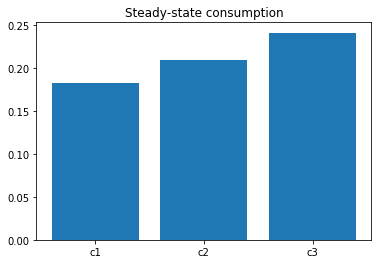

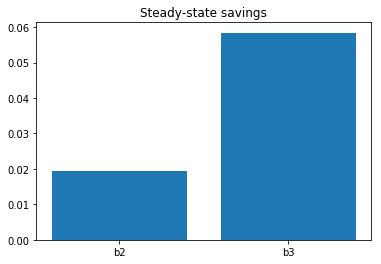

{'b_ss': array([0.01931274, 0.05841159]),
 'c_ss': array([0.18241256, 0.20961491, 0.24087382]),
 'w_ss': 0.20172529359537983,
 'r_ss': 2.4330302535700885,
 'K_ss': 0.07772432611790048,
 'Y_ss': 0.6827625321689779,
 'C_ss': 0.6329012827930353,
 'EulErr_ss': array([ 4.58641125e-10, -8.88931595e-10]),
 'RCerr_ss': 6.938893903907228e-18,
 'ss_time': 0.0010533003926358419}

In [16]:
get_SS(params, bvec_guess, ss_graphs = True)

In [17]:
β = 0.55               
params = [β, σ, nvec, L, A, α, δ, ss_tol]

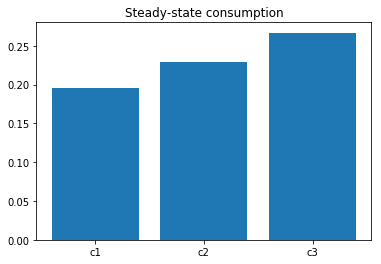

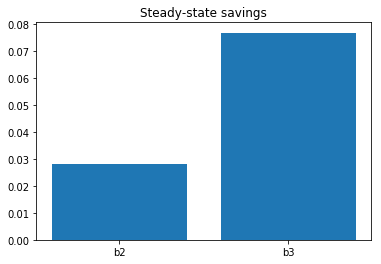

{'b_ss': array([0.02817696, 0.07686557]),
 'c_ss': array([0.19597535, 0.22861559, 0.26669216]),
 'w_ss': 0.22415231186618687,
 'r_ss': 1.886360000063548,
 'K_ss': 0.10504252544893955,
 'Y_ss': 0.7586693632394017,
 'C_ss': 0.691283104418148,
 'EulErr_ss': array([-6.82537689e-08, -2.50616949e-08]),
 'RCerr_ss': 0.0,
 'ss_time': 0.0005736863046274521}

In [18]:
get_SS(params, bvec_guess, ss_graphs = True)

Here we see that an increase in $\beta$ leads to an increase in consumption and investment each period, as well as higher wages and a lower interest rate.
<br>
<br>
The intuition behind this is that households are more patient, and receive more utility by consu,ing in the future than they did before. As a result, they will save more now in order to consume more tomorrow.

**Exercise 2.3**

In [19]:
# Set parameters
β = 0.96**20               # 20-year discount factor
T = 25                        # Steady-state horizon
tol = 1e-9                    # tolerance
xi = 0.2
nvec = np.array([1, 1, 0.2])  # Labour supply
eul_tol = 1e-6                # tolerance for Euler errors
max_iter = 10_000
params = [β, σ, nvec, L, A, α, δ, eul_tol, max_iter]

In [20]:
output_ss = get_SS(params, bvec_guess)
b2bar = output_ss['b_ss'][0]
b3bar = output_ss['b_ss'][1]
b_ss = np.array([b2bar, b3bar])

b_ss

array([0.01931274, 0.05841159])

In [21]:
b21 = 0.8 * b2bar
b31 = 1.1 * b3bar
bvec_guess = np.array([b21, b31])

In [22]:
K1 = b21 + b31
Kbar = b2bar + b3bar
Kpath = np.linspace(K1, Kbar, T)
Kpath = np.append(Kpath, Kbar)

In [23]:
def get_wr_paths(T, Kpath, Kbar, params):
    
    rpath = np.zeros(T)
    wpath = np.zeros(T)
    for t in range(T):
        rpath[t] = get_r(Kpath[t], params)
        wpath[t] = get_w(Kpath[t], params)
    rbar = get_r(Kbar, params)
    wbar = get_w(Kbar, params)
    rpath = np.append(rpath, rbar)
    wpath = np.append(wpath, wbar)
    
    return np.array([rpath, wpath])

In [24]:
def b32_EulErr(b32, b32_params):
    
    b21    = b32_params[0]
    b22    = b32_params[1]
    rpath  = b32_params[2]
    wpath  = b32_params[3]
    params = b32_params[4]
    
    c1 = (1 + rpath[0]) * b21 + wpath[0] * params[2][1] - b32
    u1 = u_prime(c1, params)
    c2 = (1 + rpath[1]) * b32 + wpath[1] * params[2][2]
    u2 = u_prime(c2, params)
    
    return u1 - params[0] * (1 + rpath[1]) * u2

In [25]:
def get_b32(b21, b22, rpath, wpath, params, bvec_guess):
    
    b32_params = [b21, b22, rpath, wpath, params]
    result = opt.root(b32_EulErr, bvec_guess[0], args = b32_params, 
                      tol = params[7])
    b32 = result.x
    b32_EulErrs = result.fun
    
    return np.array([b32, b32_EulErrs])

In [26]:
def b_EulErr(b, b_params):
    
    t = b_params[0]
    rpath = b_params[1]
    wpath = b_params[2]
    params = b_params[3]
    
    c21 = wpath[t] * params[2][0] - b[0]
    u21 = u_prime(c21, params)
    c22 = (1 + rpath[t+1]) * b[0] + wpath[t+1] * params[2][1] - b[1]
    u22 = u_prime(c22, params)
    b2_EulErr = u21 - params[0] * (1 + rpath[t+1]) * u22
    
    c31 = (1 + rpath[t+1]) * b[0] + wpath[t+1] * params[2][1] - b[1]
    u31 = u_prime(c31, params)
    c32 = (1 + rpath[t+2]) * b[1] + wpath[t+2] * params[2][2]
    u32 = u_prime(c32, params)
    b3_EulErrs = u31 - params[0] * (1 + rpath[t+2]) * u32
    
    return np.array([b2_EulErr, b3_EulErrs])

In [27]:
def get_b(t, rpath, wpath, params, bvec_guess):
    
    b_params = [t, rpath, wpath, params]
    result = opt.root(b_EulErr, bvec_guess, args = b_params, tol = params[7])
    b = result.x
    b_EulErrs = result.fun
    
    return np.array([b, b_EulErrs])

In [28]:
def aggregate_errs(Kpath, rpath, wpath, bmat, params):
    
    L = params[2].sum()
    C = L * wpath[:-1] + (1 + rpath[:-1]) * bmat[:-1,0] - bmat[1:,0] + \
                        (1 + rpath[:-1]) * bmat[:-1,1] - bmat[1:,1]
    Y = params[4] * (Kpath[:-1]**params[5]) * L**(1 - params[5])
    
    agg_err = Y - C - Kpath[1:] + (1 - params[6]) * Kpath[:-1]
    max_agg_err = np.abs(agg_err).max()
    
    return max_agg_err

In [29]:
def time_chart(T, rpath, wpath, Kpath, bvec_guess, b_ss, params):
    
    bmat = np.zeros((T+1, 2))
    bmat[0,:] = bvec_guess
    EulErrs = np.zeros((T+1, 2))
    cols = [0,1]
    for t in range(T-1):
        rows = [t+1, t+2]
        bmat[rows, cols], EulErrs[rows, cols] = get_b(t, rpath, wpath, 
                                                      params, 
                                                      bvec_guess)
    
    bmat[1,1], EulErrs[1,1] = get_b32(bmat[0,0], bmat[0,1], rpath, wpath, 
                                      params, 
                                      bvec_guess)
    max_EulErrs = np.abs(EulErrs).max(axis = 0)
    agg_errs = aggregate_errs(Kpath, rpath, wpath, bmat, params)
    
    
    return bmat, max_EulErrs, agg_errs

In [30]:
def Kprime(bmat, Kbar):
    
    Kp_path = bmat[:-1,:].sum(axis = 1)
    Kp_path = np.append(Kp_path, Kbar)
    
    return Kp_path

In [31]:
def TPI(T, Kpath, Kbar, bvec_guess, b_ss, params, tol, max_iter):
    
    dist = tol + 1
    i = 0
    
    while (dist > tol) & (i < max_iter):
        i += 1
        rpath, wpath = get_wr_paths(T, Kpath, Kbar, params)
        bmat, max_EulErrs, max_agg_errs = time_chart(T, rpath, wpath, Kpath, bvec_guess, b_ss, params)
        Kp_path = Kprime(bmat, Kbar)
        dist = scipy.linalg.norm(Kp_path - Kpath, 2)
        Kpath = xi * Kp_path + (1 - xi) * Kpath
    
    print('Maximum of the absolute value of generation 2: ', max_EulErrs[0])
    print('Maximum of the absolute value of generation 3: ', max_EulErrs[1])
    print('Maximum of the absolute value of all aggregate resourse constraint error:\n', max_agg_errs)
    
    return Kpath, rpath, wpath

In [32]:
Kstd_path, rstd_path, wstd_path = TPI(T, Kpath, Kbar, bvec_guess, b_ss, 
                                      params, tol, max_iter)

Maximum of the absolute value of generation 2:  3.2133999638972455e-07
Maximum of the absolute value of generation 3:  9.464220340760221e-08
Maximum of the absolute value of all aggregate resourse constraint error:
 0.019312736060194242


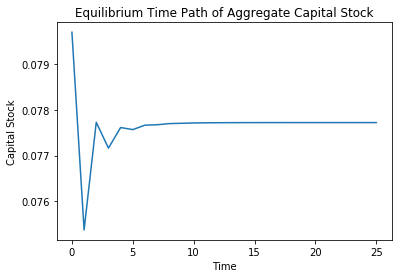

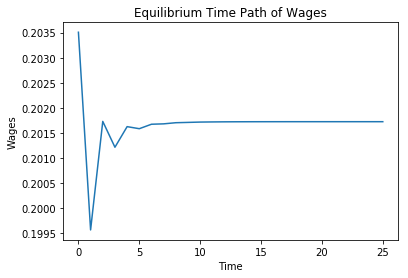

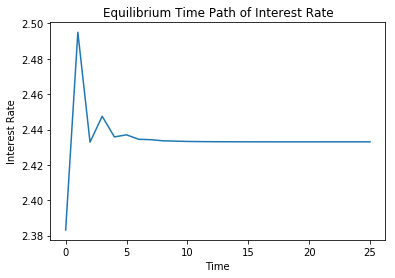

In [33]:
plt.plot(Kstd_path)
plt.title('Equilibrium Time Path of Aggregate Capital Stock')
plt.xlabel('Time')
plt.ylabel('Capital Stock')
plt.show()

plt.plot(wstd_path)
plt.title('Equilibrium Time Path of Wages')
plt.xlabel('Time')
plt.ylabel('Wages')
plt.show()

plt.plot(rstd_path)
plt.title('Equilibrium Time Path of Interest Rate')
plt.xlabel('Time')
plt.ylabel('Interest Rate')
plt.show()

In [34]:
Kstd_dist = np.abs(Kstd_path - Kbar)
err = 1e-5
loc = np.where(Kstd_dist < err)[0]
print('Periods for the economy to get within 1e-5 of the steady state aggregate capital: ', loc.min())
loc_cons = np.ediff1d(loc) == 1
print('Periods for the economy stays within 1e-5 of the steady state aggregate capital: ', loc[-len(loc_cons)])

Periods for the economy to get within 1e-5 of the steady state aggregate capital:  2
Periods for the economy stays within 1e-5 of the steady state aggregate capital:  10
